# Python enviorment options and data analysis

In [54]:
# Import of all libraries used in project

# Data manipulation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Data visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

# Models and optimizators
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import pyswarms as ps

In [73]:
# Default configuration for data visualization
%matplotlib inline
%config InlineBackend.figure_formats = ['png']

# More in https://matplotlib.org/stable/tutorials/introductory/customizing.html#matplotlib-rcparams
custom_backend_params = {
    'figure.dpi':150,
    'savefig.dpi':300
}
sns.set(rc=custom_backend_params)
sns.set_style(style='white')

In [13]:
# Use a seed for reproducibility purposes
np.random.seed(42)

In [14]:
# Loading the data in memory
df_stars = pd.read_csv(
    'data\star_classification.csv'
)

df_stars.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [15]:
# Renaming dataframe columns to better understanding
columns_mapper = {
    'obj_ID': 'object_id',
    'alpha': 'right_ascension_angle',
    'delta': 'declination_angle',
    'u': 'ultraviolet_filter',
    'g': 'green_filter',
    'r': 'red_filter',
    'i': 'near_infrared_filter',
    'z': 'infrared_filter',
    'run_ID': 'run_id',
    'rerun_ID': 'rerun_id',
    'cam_col': 'camera_column',
    'field_ID': 'field_id',
    'spec_obj_ID': 'spectroscopic_object_id',
    'class': 'class',
    'redshift': 'redshift',
    'plate': 'plate_id',
    'MJD': 'modified_julian_date',
    'fiber_ID': 'fiber_id'
}

df_stars.rename(
    columns=columns_mapper,
    inplace=True
)

In [16]:
# Mapping of Unique IDs, Input Features and Output Class columns of dataframe
input_columns = [
    'right_ascension_angle',
    'declination_angle',
    'ultraviolet_filter',
    'green_filter',
    'red_filter',
    'near_infrared_filter',
    'infrared_filter',
    'redshift',
    'camera_column',
    'plate_id'
]

output_column = ['class']

id_columns = [
    'object_id',
    'spectroscopic_object_id',
    'run_id',
    'rerun_id',
    'field_id',
    'plate_id',
    'fiber_id'
    'modified_julian_date',
]


In [17]:
# Keeping only important columns in dataframe
df_stars = df_stars.loc[:, input_columns + output_column]
df_stars.describe()

,right_ascension_angle,declination_angle,ultraviolet_filter,green_filter,red_filter,near_infrared_filter,infrared_filter,redshift,camera_column,plate_id
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,0.576661,3.511610,5137.009660
std,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,0.730707,1.586912,2952.303351
min,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,-0.009971,1.000000,266.000000
25%,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,0.054517,2.000000,2526.000000
50%,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,0.424173,4.000000,4987.000000
75%,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,0.704154,5.000000,7400.250000
max,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,7.011245,6.000000,12547.000000


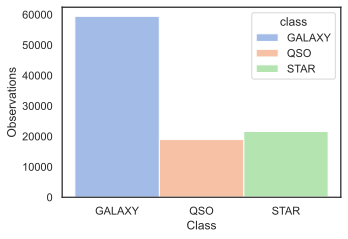

In [18]:
# Checking distribution between the three classes
fig, axes = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(5, 3.5)
)

sns.histplot(
    data=df_stars,
    x='class',
    hue='class',
    palette='muted'
)

plt.xlabel('Class')
plt.ylabel('Observations')

plt.show()

More than the half of observations are from the 'GALAXY' class with remaining rows almost equaly divided by the another two classes, 'STAR' and 'QSO' (quasar object). In this case may not be necessary balance the observations between classes.

# Classification models

In [19]:
# Splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    df_stars[input_columns].to_numpy(),
    df_stars[output_column].to_numpy(),
    test_size=0.33,
    stratify=df_stars[output_column].to_numpy()
)

## Default Random Forest

In [20]:
# Training a random forest classifier and checking
# the accuracy score on test dataset
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train.ravel())
rfc_accuracy = rfc.score(X_test, y_test.ravel())
print(f'Accuracy score for test data: {100*rfc_accuracy:.2f}%')

Accuracy score for test data: 97.96%


## Optimized (PSO) Random Forest

In [21]:
# Custom cost function to be minimized in PSO

# Return the all accuracies using the train
# dataset and the parameters of particles
def cost_function(x):
    particles_accuracy = np.array([])

    for particle_number in range(x.shape[0]):
        rfc_pso = RandomForestClassifier(
            min_samples_split=x[particle_number, 0],
            min_samples_leaf=x[particle_number, 1],
            min_weight_fraction_leaf=x[particle_number, 2]
        )

        local_accuracy = cross_val_score(
            rfc_pso,
            X_train,
            y_train.ravel(),
            cv=5
        )

        mean_accuracy = np.mean(local_accuracy)

        particles_accuracy = np.append(
            particles_accuracy,
            np.array([-1*mean_accuracy]) # To find a minimum value (max accuracy)
        )
    
    return particles_accuracy

In [24]:
# Setting-up swarm hyperparameters

# More in: https://pyswarms.readthedocs.io/en/latest/api/pyswarms.single.html
# c1: cognitive parameter (increase to follow its personal best position)
# c2: social parameter (increase to follow swarm's global best position)
# w: inertia of swarm's movement 
options_list = [
    {'c1': 0.5, 'c2': 0.3, 'w':0.9}, # default pyswarm's parameters
    {'c1': 0.5, 'c2': 0.3, 'w':1.2}, # increasing inertial parameter
    {'c1': 0.8, 'c2': 0.2, 'w':0.9}, # increasing cognitive parameter
    {'c1': 0.2, 'c2': 0.8, 'w':0.9}  # increasing social parameter
]

# Create min and max bounds for Random Forest parameters
bounds = (np.array([0, 0, 0]), np.array([0.5, 0.5, 0.5]))

# Lists to store cost and position history for each option dictionary
cost_list = []
position_list = []
optimizer_list = []

for options in options_list:
    # Call a instance of PSO
    optimizer = ps.single.GlobalBestPSO(
        n_particles=15,
        dimensions=3,
        options=options,
        bounds=bounds
    )

    # Perform optimization
    cost, pos = optimizer.optimize(cost_function, iters=10)

    # Store cost, position and optimizer for actual option's dictionary
    cost_list.append(cost)
    position_list.append(pos)
    optimizer_list.append(optimizer)



2022-03-27 10:59:22,898 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-.957
2022-03-27 11:18:48,665 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9565373134328358, best pos: [0.01700624 0.00046712 0.04420685]
2022-03-27 11:18:48,671 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 1.2}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-.949
2022-03-27 11:35:46,712 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9485522388059702, best pos: [0.098991   0.04830726 0.01640384]
2022-03-27 11:35:46,717 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.8, 'c2': 0.2, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-.945
2022-03-27 11:53:57,861 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -

In [71]:
# Using the best positions of each option dictionary
# to train and test the Random Forest classifier
dict_swarm_options = {
    1: 'Default parameters',
    2: 'Inertial increase',
    3: 'Cognitive increase',
    4: 'Social increase'
}

accuracy_test_score = []

for i, position in enumerate(position_list, start=1):
    rfc_pso = RandomForestClassifier(
                min_samples_split=position[0],
                min_samples_leaf=position[1],
                min_weight_fraction_leaf=position[2]
            )

    rfc_pso.fit(X_train, y_train.ravel())

    rfc_pso_accuracy = rfc_pso.score(X_test, y_test.ravel())
    accuracy_test_score.append(rfc_pso_accuracy)
    
    print(f'Accuracy score (PSO with {dict_swarm_options.get(i)}) for test data: {100*rfc_pso_accuracy:.2f}%')    

Accuracy score (PSO with Default parameters) for test data: 95.72%
Accuracy score (PSO with Inertial increase) for test data: 94.58%
Accuracy score (PSO with Cognitive increase) for test data: 94.74%
Accuracy score (PSO with Social increase) for test data: 94.80%


Trying to use the PSO to find the best combination of three Random Forest hyperparameters (min_samples_split, min_samples_leaf and in_weight_fraction_leaf) varying between 0 and 0.5 brought a worse accuracy (95.72%) compared to default Random Forest hyperparameters (97.96%).

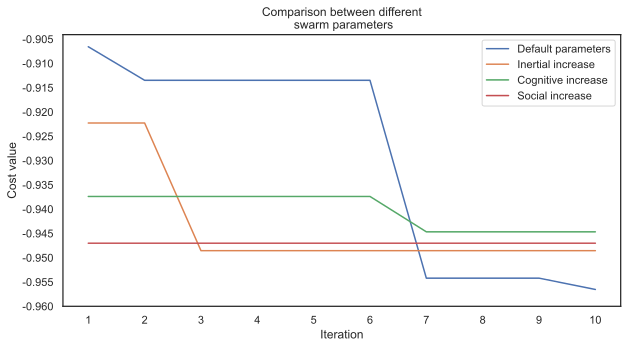

In [63]:
# Plotting cost history by iterations for 4 parameters combination
fig, axes = plt.subplots(1, 1, figsize=(10, 5))

for i, optimizer in enumerate(optimizer_list, start=1):
    sns.lineplot(
        x=[x for x in range (1, len(optimizer.cost_history)+1)],
        y=optimizer.cost_history,
        label=dict_swarm_options.get(i)
    )

plt.title('Comparison between different\n swarm parameters')
plt.legend(loc='upper right')

plt.xticks([x for x in range(1, len(optimizer.cost_history)+1)])
plt.yticks(np.arange(-0.96, -0.901, step=0.005), np.arange(-0.96, -0.901, step=0.005))
axes.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

plt.xlabel('Iteration')
plt.ylabel('Cost value')

plt.show()

In addition to the default parameters having brought a better final cost (-0.9565) and test result (95.69% accuracy), we can see in previous chart that a increase in iterations number maybe bring even better results.

Incrementing inertial parameter resulted in a faster optimization (best result at 3rd iteration) and the second best result in cost history and test result.

A cognitive parameter increase doesn't affected the final result of optimization, resulting a final cost close to initial cost.

Lastly, trying to emphasize the social parameter resulted in no optimization even after 10 iterations and in the 2nd worst final cost, not being a good strategy for this kind of problem.


In [64]:
# Call a instance of PSO with default options
optimizer = ps.single.GlobalBestPSO(
    n_particles=15,
    dimensions=3,
    options=options_list[0], # Default parameters
    bounds=bounds
)

# Perform optimization
cost, pos = optimizer.optimize(cost_function, iters=30)

2022-03-27 15:31:42,917 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|30/30, best_cost=-.959
2022-03-27 16:28:14,737 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9585970149253731, best pos: [0.04949476 0.00389503 0.03872658]


In [72]:
# Using the best position for default parameters with 30 
# iterations to train and test the Random Forest classifier
rfc_pso = RandomForestClassifier(
            min_samples_split=pos[0],
            min_samples_leaf=pos[1],
            min_weight_fraction_leaf=pos[2]
        )

rfc_pso.fit(X_train, y_train.ravel())

rfc_pso_accuracy = rfc_pso.score(X_test, y_test.ravel())

print(f'Accuracy score (PSO with {dict_swarm_options.get(1)}) for test data: {100*rfc_pso_accuracy:.2f}%')    

Accuracy score (PSO with Default parameters) for test data: 95.67%


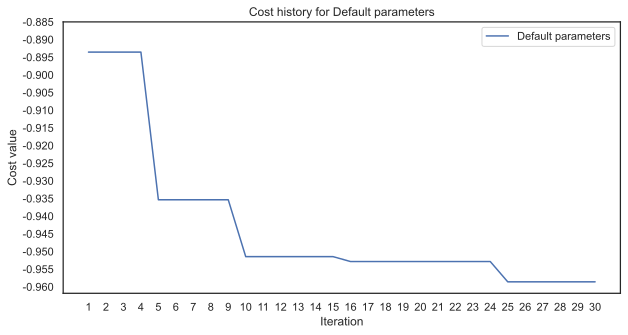

In [70]:
# Plotting cost history by iterations for default parameters with 30 iterations
fig, axes = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(
    x=[x for x in range (1, len(optimizer.cost_history)+1)],
    y=optimizer.cost_history,
    label=dict_swarm_options.get(1) # Default parameters
)

plt.title(f'Cost history for {dict_swarm_options.get(1)}')
plt.legend(loc='upper right')

plt.xticks([x for x in range(1, len(optimizer.cost_history)+1)])
plt.yticks(np.arange(-0.96, -0.881, step=0.005), np.arange(-0.96, -0.881, step=0.005))
axes.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

plt.xlabel('Iteration')
plt.ylabel('Cost value')

plt.show()

Even with 30 iterations, the PSO with default parameters (the best option between the four tested previously) reached a final cost equal -0.9585 and a test validation with 95.67% accuracy, both lower than using Random Forest classifier without any particles swarm optimization (PSO).

However the PSO proved to be a functional optimization algorithm, minimizing the cost (and increasing accuracy) of Random Forest model. In future tries changing number of particles or trying a new range of cognitive, social and inertial parameters can be a valid option to reach a better result.